<a href="https://colab.research.google.com/github/KhaledBinIslam/test/blob/master/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Day1/Emo3-20230203T035411Z-001.zip -d /content/drive/MyDrive/Day1/

In [2]:
import torch
import math
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import time
import os
import copy


In [3]:
class NNM(nn.Module):
  def __init__(self) -> None:
    super(NNM, self).__init__()
    self.linear1 = nn.Linear(37632, 4096)
    self.linear2 = nn.Linear(4096, 1024)
    self.linear3 = nn.Linear(1024,3)
    self.activation = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x =  self.linear1(x)
    x =  self.linear2(x)
    x =  self.linear3(x)
    output = self.softmax(x)
    return output


In [4]:
path = '/content/drive/MyDrive/Day1/Emo3'
train_size = 0

def load_data(test_split, batch_size):
  dataset = torchvision.datasets.ImageFolder(path, transform=transforms.ToTensor())
  global test_size
  global train_size 
  dataset_size = len(dataset)
  test_size = int(test_split * dataset_size)
  train_size = dataset_size - test_size 
    
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  return train_loader, test_loader 

batch_size = 100

train_loader, test_loader = load_data(0.1, batch_size)
dataset_sizes = {'train': train_size, 'val' : test_size}

In [5]:
dataset_sizes

{'train': 5791, 'val': 643}

In [6]:
def NN_training( model, epochs, optimizer, scheduler):

  best_model = copy.deepcopy( model.state_dict() )
  bestNN_Accuracy = 0.0

  for epoch in range(epochs):

    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
      images = torch.flatten(images, 1) 
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(images.float())
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      
      epoch_loss +=loss
      #print(f'Loss Value {loss}')
    scheduler.step()
    model.eval()
    accuracy = 0
    epoch_accuracy = 0
    for images, labels in test_loader:
      images = torch.flatten(images, 1) 
      images = images.to(device)
      labels = labels.to(device)
      #optimizer.zero_grad()
      with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        epoch_accuracy += torch.sum(preds == labels.data)
    print(f'Epoch {epoch}: Acuuracy: {epoch_accuracy}') 
    print(f'Epoch {epoch}: loss: {epoch_loss}')
    if bestNN_Accuracy < epoch_accuracy:
      bestNN_Accuracy = epoch_accuracy
      best_model = copy.deepcopy( model.state_dict() )
  return best_model






In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NNM().to(device)
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#trained_model = NN_training(model, 10, optimizer_conv, exp_lr_scheduler)

In [8]:
trained_model = NN_training(model, 15, optimizer_conv, exp_lr_scheduler)

Epoch 0: Acuuracy: 308
Epoch 0: loss: 61.958133697509766
Epoch 1: Acuuracy: 317
Epoch 1: loss: 61.359901428222656
Epoch 2: Acuuracy: 312
Epoch 2: loss: 61.0869026184082
Epoch 3: Acuuracy: 311
Epoch 3: loss: 60.89249038696289
Epoch 4: Acuuracy: 318
Epoch 4: loss: 60.7661247253418
Epoch 5: Acuuracy: 324
Epoch 5: loss: 60.57501220703125
Epoch 6: Acuuracy: 321
Epoch 6: loss: 60.339290618896484
Epoch 7: Acuuracy: 321
Epoch 7: loss: 60.1204719543457
Epoch 8: Acuuracy: 322
Epoch 8: loss: 60.093936920166016
Epoch 9: Acuuracy: 323
Epoch 9: loss: 60.055023193359375
Epoch 10: Acuuracy: 322
Epoch 10: loss: 60.02408981323242
Epoch 11: Acuuracy: 320
Epoch 11: loss: 59.97553253173828
Epoch 12: Acuuracy: 322
Epoch 12: loss: 59.9449348449707
Epoch 13: Acuuracy: 318
Epoch 13: loss: 59.90302658081055
Epoch 14: Acuuracy: 319
Epoch 14: loss: 59.87333297729492


In [9]:
torch.save(trained_model, '/content/drive/MyDrive/Day1/models/NN-Emo_3-class-model.pt')

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [11]:
def visualize_model(model, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    class_names = ['Neutral', 'Happy', 'Sad']
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
          images = torch.flatten(inputs, 1) 
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, preds = torch.max(outputs, 1)
          print(preds)
          for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')

            imshow(inputs.cpu().data[j])
                
          plt.show()
          return

tensor([2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0,
        0, 2, 0, 0], device='cuda:0')


ValueError: ignored

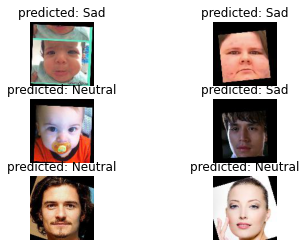

In [20]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NNM().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Day1/models/NN-Emo_3-class-model.pt'))
visualize_model(model, 6)